## Dependencies

In [16]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt
import openpyxl

## Reading in parameters and topology data

In [17]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

    #Volume-head relationship:
def InputHead(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column], inputdata[head_column]))
    return data_volhead
headvol_Ormset=InputHead('data/Ormset_Data.xlsx')

def InputHead2(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head2')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column].dropna(), inputdata[head_column].dropna()))
    return data_volhead
headvol_Buaset=InputHead2('data/Ormset_Data.xlsx')

    #Flow-head relationship:
def InputFlow(data_file): 
    inputdata = pd.read_excel(data_file, sheet_name='flow')
    data_flowhead = {}
    data_flowhead['ormset_heawvlow'] = inputdata[['Moh','m3/s']].dropna()
    return data_flowhead
headflow=InputFlow('data/Ormset_Data.xlsx')

display(topology)
display(headvol_Ormset)
display(headflow)

def interpolate_head(volume, head_dict):
    volumes = list(head_dict.keys())
    heads = list(head_dict.values())
    return np.interp(volume, volumes, heads)

test=interpolate_head(45, headvol_Ormset)
print(test)


{'ormset': Ormsetfoss  Pmin  Pmax  Vmax  Vmin  Vstart  Qmin  Qmax  Pump_min  Pump_max  \
 Hydro1       0.0  43.0  45.0   0.0    45.0   0.0  12.0       0.0       0.0   
 Hydro2       0.0  30.0  20.0   0.0    20.0   0.0  12.0       0.0       1.6   
 
 Ormsetfoss    Q    LRL    HRL  RL_start  Spill_min  Spill_max  
 Hydro1      4.0  375.0  389.0     389.0        0.0       50.0  
 Hydro2      2.0  326.0  331.5     331.5        0.0       50.0  }

{0.0: 375.0,
 2.08333: 375.99242,
 4.16667: 376.83333,
 6.25: 377.63462,
 8.33333: 378.40476,
 10.41667: 379.09314,
 12.5: 379.70588,
 14.58333: 380.30093,
 16.66667: 380.87963,
 18.75: 381.45833,
 20.83333: 382.03509,
 22.91667: 382.58333,
 25.0: 383.13158,
 27.08333: 383.67982,
 29.16667: 384.22807,
 31.25: 384.77632,
 33.33333: 385.32456,
 35.41667: 385.85417,
 37.5: 386.35714,
 39.58333: 386.85317,
 41.66667: 387.33333,
 43.75: 387.79348,
 45.83333: 388.24638,
 47.91667: 388.65278,
 50.0: 389.0}

{'ormset_headflow':      Moh  m3/s
 0  388.0   0.0
 1  388.2   4.9
 2  388.5  20.4
 3  389.0  68.4}

388.0652204347847


In [18]:
start = '2018-01-01 00:00:00'
end = '2018-12-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

    #Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.008)

hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour

## Functions


In [19]:


# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 30, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}, 
             'states': {100: 1, 75: 0.75, 50: 0.5, 25: 0.25, 0:0 }}




# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j, s):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j, s): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j, s):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j, s ):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j, s):
    return model.v0[i]

def head_bounds(model,i,j, s):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j, s):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow

def inflow1_scenario(model, i, j, s):
    if i=='Hydro1':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 0.5)[j]
    elif i == 'Hydro2':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 0.5)[j]


# Constraints
def load_rule(model, j, s):
    return model.p['Hydro1',j, s] + model.p['Hydro2',j, s] + model.m['Buy',j, s] == model.L[j] - (model.r[j, s])

def power_rule(model,i, j, s):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j, s] == model.p[i, j, s]#MW

def vol_rule(model, i, s):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods), s ] >= model.v0[i] - tolerance



# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])


#def v_init_rule(model, i, v):
   #return model.v_init[i,v]==model.v0[i]*v/100


    
def volume_change_rule(model, i, j, s):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j , s] == (model.v_init1) - (model.q[i, j, s] *fm3) +(model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j, s] == (model.v_init2) - (model.q[i, j, s] *fm3)  -(model.s[i,j,s]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j , s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) +(model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i =='Hydro2':
            return model.v[i, j, s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) -(model.s[i,j,s]*fm3)   
        
        
    
         
    
def OBJ_one_stage(model):
    return sum(model.probs[s] * (model.Ri*model.r[j, s] + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios ) + model.alpha


def OBJ_last_stage(model):
    return sum(model.probs[s] * (model.Ri*model.r[j, s] + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios )




## Solve one stage setup


In [20]:
def solve_last_stage(constants, topology, stage, states):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
    
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
 
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_last_stage, sense=pyo.minimize)
    
        
    return model
    


def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True) 
            
    return results, model

def displayresults(model):
    return print(model.dual.display())




In [21]:
stages=reversed(range(1, 52 + 1, 1))
scenarios= ['High', 'Avg', 'Low']
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

expected={}
end_volume={}
Dual_values1={}
Dual_values2={}

for state in state_combinations: 
        m=solve_last_stage(constants, topology, 52, state)
        solve(m)
        expected[52,state]=m.obj()/len(m.scenarios)
        Dual_values1[52, state]= (m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'High'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Avg'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Low'])))/len(m.scenarios)
        Dual_values2[52, state]= (m.dual.get((m.volume_change_cons['Hydro2', max(m.periods), 'High'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Avg'])) + m.dual.get((m.volume_change_cons['Hydro1', max(m.periods), 'Low'])))/len(m.scenarios)
        



Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3549 rows, 8619 columns and 10635 nonzeros
Model fingerprint: 0x4bbc3c96
Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  Objective range  [1e+01, 2e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [3e-02, 1e+02]
Presolve removed 2559 rows and 5667 columns
Presolve time: 0.02s
Presolved: 990 rows, 2952 columns, 3936 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2091153e+05   2.260464e+01   0.000000e+00      0s
    1434    3.9475600e+05   0.000000e+00   0.000000e+00      0s

Solved in 1434 iterations and 0.06 seconds (0.02 work units)
Optimal objective  3.947560021e+05
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64

In [22]:
def solve_one_stage(constants, topology, stage, states, alpha_values, dual_res1, dual_res2):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
    
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    
    #Creating future cost variable
    model.alpha=pyo.Var()
 
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    model.alpha_cons=pyo.ConstraintList()
    
    phi_values = []
    lambda1_values = []
    lambda2_values =[]
    state_volumes=[]
    # Calculate b values
    for key in alpha_values:
        if key[0]==stage+1:
            state_volumes.append(key[1])
            phi_values.append(alpha_values[key])
            lambda1_values.append(dual_res1[key])
            lambda2_values.append(dual_res2[key])
        else:
            pass
    
    # Calculate x values
    for i in range(len(state_volumes)):
        model.alpha_cons.add(model.alpha >= phi_values[i] - lambda1_values[i]*(sum(model.v['Hydro1', max(model.periods), s] for s in model.scenarios)/len(model.scenarios)  - (state_volumes[i][0])) - lambda2_values[i]*(sum(model.v['Hydro2', max(model.periods), s] for s in model.scenarios)/len(model.scenarios)  - (state_volumes[i][1]))) 
            
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_one_stage, sense=pyo.minimize)
    
        
    return model
    

In [23]:
stages=reversed(range(1, 51 + 1, 1))
scenarios= ['High', 'Avg', 'Low']
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

alpha_matrix = []
alpha_test = {}

for stage in stages:
    alpha_row = []
    for state in state_combinations:
        m2=solve_one_stage(constants, topology, stage, state, expected, Dual_values1, Dual_values2)
        solve(m2)
        expected[stage, state]=(m2.obj())/len(m2.scenarios)
        alpha_test[stage+1, state]=(m2.alpha.value)
        end_volume[stage, state] = (m2.v['Hydro1', max(m2.periods), 'Avg'].value + m2.v['Hydro2', max(m2.periods), 'Avg'].value)
        Dual_values1[stage, state] = (m2.dual.get((m2.volume_change_cons['Hydro1', max(m2.periods), 'High'])) + m2.dual.get((m2.volume_change_cons['Hydro1', max(m2.periods), 'Avg'])) + m2.dual.get((m2.volume_change_cons['Hydro1', max(m2.periods), 'Low'])))/len(m2.scenarios)
        Dual_values2[stage, state] = (m2.dual.get((m2.volume_change_cons['Hydro2', max(m2.periods), 'High'])) + m2.dual.get((m2.volume_change_cons['Hydro2', max(m2.periods), 'Avg'])) + m2.dual.get((m2.volume_change_cons['Hydro2', max(m2.periods), 'Low'])))/len(m2.scenarios)
        
        alpha_row.append(m2.alpha.value)
    alpha_matrix.append(alpha_row)



alpha_matrix = np.array(alpha_matrix)


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3585 rows, 8620 columns and 10737 nonzeros
Model fingerprint: 0x4db3583c
Coefficient statistics:
  Matrix range     [4e-03, 3e+03]
  Objective range  [1e+00, 3e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [5e-03, 1e+05]
Presolve removed 2667 rows and 5872 columns
Presolve time: 0.02s
Presolved: 918 rows, 2748 columns, 3660 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2893485e+05   2.977090e+01   0.000000e+00      0s
    1593    6.7814473e+05   0.000000e+00   0.000000e+00      0s

Solved in 1593 iterations and 0.06 seconds (0.02 work units)
Optimal objective  6.781447262e+05
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64

KeyError: 0

In [30]:
column_names = [f'Stage {stage}' for stage in reversed(range(1, 50 + 1, 1))]
row_names = [f'State {i + 1}' for i in range(len(state_combinations))]
tuple_names = [state_combinations[i] for i in range(len(state_combinations))]
alpha_matrix_backup = alpha_matrix.copy()

#alpha_matrix_last = np.array(alpha_list).reshape(-1, 1)
#alpha_matrix_last = alpha_matrix_last.reshape(alpha_matrix.shape[0], -1)

alpha_matrix = np.array(alpha_matrix)
print(alpha_matrix.shape)
print(alpha_matrix.size)
print(alpha_matrix)
#print("Size of alpha_matrix before horizontal stack:", alpha_matrix.shape)
#print("Size of alpha_matrix_last before horizontal stack:", alpha_matrix_last.shape)

# Perform the horizontal stack
#alpha_matrix_new = np.hstack((alpha_matrix_last, alpha_matrix))
#display(alpha_matrix_new)

#print("Size of alpha_matrix after horizontal stack:", alpha_matrix_new.shape)

alpha_matrix = np.array(alpha_matrix).reshape(len(row_names), len(column_names))

# Convert the alpha_matrix to a DataFrame
alpha_df = pd.DataFrame(alpha_matrix, index=tuple_names, columns=column_names)


# Define the file name
excel_file_name = 'data/water_values.xlsx'

# Save the DataFrame to an Excel file
alpha_df.to_excel(excel_file_name, index=True)

#print(f'Water values has been saved to {excel_file_name}')

(36, 50)
1800
[[131585.3340302  131585.3340302  131585.3340302  ... 276776.94219372
  273806.69686824 273806.69686824]
 [273806.69686824 273806.69686824 273806.69686824 ... 345530.77743986
  345530.77743986 345530.77743986]
 [345530.77743986 345530.77743986 349258.43665628 ... 394645.05651532
  394645.05651532 394645.05651532]
 ...
 [390411.61480347 390411.61480347 390411.61480347 ... 314401.61854295
  314401.61854295 314401.61854295]
 [314401.61854295 314401.61854295 314401.61854295 ... 368387.32560084
  368387.32560084 368387.32560084]
 [368387.32560084 368387.32560084 368387.32560084 ... 392458.65968801
  392458.65968801 392458.65968801]]


## Solving forward

In [8]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt
import openpyxl

start = '2018-01-01 00:00:00'
end = '2018-12-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)


def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.008)



In [9]:
## Contstraints and constants

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 30, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}, 
             'states': {100: 1, 75: 0.75, 50: 0.5, 25: 0.25, 0:0 }}

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j, s):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j, s): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j, s):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j, s ):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j, s):
    return model.v0[i]

def head_bounds(model,i,j, s):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j, s):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow

def inflow1_scenario(model, i, j, s):
    if i=='Hydro1':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 0.5)[j]
    elif i == 'Hydro2':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 0.5)[j]


# Constraints
def load_rule(model, j, s):
    return model.p['Hydro1',j, s] + model.p['Hydro2',j, s] + model.m['Buy',j, s] == model.L[j] - (model.r[j, s])

def power_rule(model,i, j, s):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j, s] == model.p[i, j, s]#MW

def vol_rule(model, i, s):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods), s ] >= model.v0[i] - tolerance

fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
    
def volume_change_rule(model, i, j, s):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j , s] == (model.v0[i]) - (model.q[i, j, s] *fm3) +(model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j, s] == (model.v0[i]) - (model.q[i, j, s] *fm3)  -(model.s[i,j,s]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j , s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) +(model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i =='Hydro2':
            return model.v[i, j, s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) -(model.s[i,j,s]*fm3)   

### Handling water values

,Stage 50,Stage 49,Stage 48,Stage 47,Stage 46,Stage 45,Stage 44,Stage 43,Stage 42,Stage 41,...,Stage 10,Stage 9,Stage 8,Stage 7,Stage 6,Stage 5,Stage 4,Stage 3,Stage 2,Stage 1
"(0, 0)",131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,131585.334030,...,284419.686827,284419.686827,276776.942194,276776.942194,276776.942194,276776.942194,276776.942194,276776.942194,273806.696868,273806.696868
"(0, 4)",273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,273806.696868,...,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440,345530.777440
"(0, 8)",345530.777440,345530.777440,349258.436656,349258.436656,349258.436656,349258.436656,349258.436656,349258.436656,383048.379420,383048.379420,...,380622.606150,380622.606150,380622.606150,380622.606150,394645.056515,394645.056515,394645.056515,394645.056515,394645.056515,394645.056515
"(0, 12)",383615.019803,383615.019803,383615.019803,383615.019803,383615.019803,383615.019803,370975.598278,370975.598278,370975.598278,370975.598278,...,374654.693893,374654.693893,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691
"(0, 16)",366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,366512.251691,...,362258.270212,362258.270212,362258.270212,362258.270212,362258.270212,362258.270212,373151.160553,373151.160553,373151.160553,373151.160553
"(0, 20)",373151.160553,373151.160553,377136.416984,377136.416984,377136.416984,377136.416984,377136.416984,377136.416984,362548.890155,362548.890155,...,376256.500139,376256.500139,376256.500139,376256.500139,359952.099155,359952.099155,359952.099155,359952.099155,359952.099155,359952.099155
"(9, 0)",351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,351213.359579,...,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108,341455.423108
"(9, 4)",341455.423108,341455.423108,341455.423108,341455.423108,358278.334122,358278.334122,358278.334122,358278.334122,358278.334122,358278.334122,...,321898.783517,321898.783517,321898.783517,321898.783517,321898.783517,321898.783517,237038.538171,237038.538171,237038.538171,237038.538171
"(9, 8)",237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,237038.538171,...,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490,192375.161490
"(9, 12)",202136.873626,202136.873626,202136.873626,202136.873626,202136.873626,202136.873626,264242.874667,264242.874667,264242.874667,264242.874667,...,253469.386377,253469.386377,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280,237992.899280


273806.6968682382


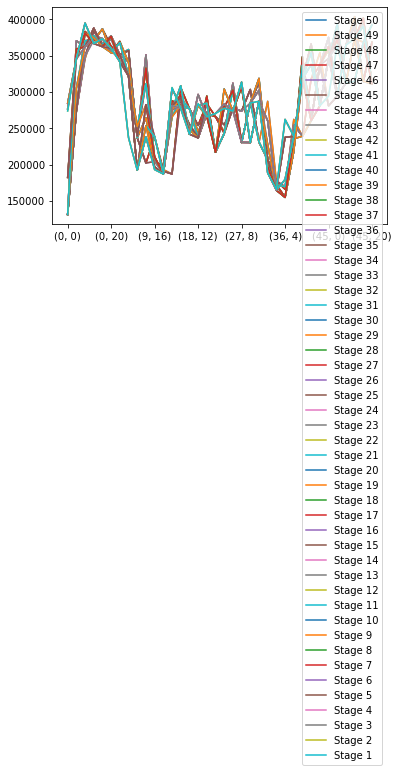

In [10]:
# Read water values and make them readable
wv = pd.read_csv('data/water_values.csv', index_col=0)
display(wv)
wv.plot()

# Define a function to convert string labels back to tuples
def label_parser(label):
    parts = label.strip('()').split(', ')
    return (int(parts[0]), int(parts[1]))

# Convert the MultiIndex labels to tuples for indexing
wv.index = wv.index.map(label_parser)

#map so that stage in stages call on the string name of the column in the dataframe when solving later
column_mapping = {i: f'Stage {i}' for i in range(1, 51)}   #this is needed because the column names are not integers, but strings
        
# Access a specific value using a tuple as the row label
value = wv.loc[(0, 0), column_mapping[1]]
print(value)

In [11]:
def solve_first_forward(constants, topology, stage):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24 + 1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
     
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    #model.alpha = pyo.Var(model.stage, model.scenarios, within=NonNegativeReals) #water values for each stage after interpolation

    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_first_stage, sense=pyo.minimize)
        
    return model



#Solving functions:
def OBJ_first_stage(model):
    return sum(model.probs[s] * (model.r[j, s] * model.Ri  + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios) #+ model.alpha

def OBJ_forward_stage(model):
    return sum(model.probs[s] * (model.r[j, s] * model.Ri  + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios) + model.alpha

def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True)             
    return results, model

def displayresults(model):
    print(model.dual.display())

In [12]:
## Solve forward loop for first stage (regular optimization problem)
stage = 1    

first_stage = solve_first_forward(constants, topology, stage) 
solve(first_stage)

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3528 rows, 8568 columns and 10572 nonzeros
Model fingerprint: 0x39ffc07d
Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  Objective range  [8e+00, 1e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [5e-03, 1e+02]
Presolve removed 2628 rows and 5781 columns
Presolve time: 0.01s
Presolved: 900 rows, 2787 columns, 3678 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0708564e+05   1.507384e+00   0.000000e+00      0s
     897    2.2323093e+05   0.000000e+00   0.000000e+00      0s

Solved in 897 iterations and 0.02 seconds (0.02 work units)
Optimal objective  2.232309265e+05


({'Problem': [{'Name': 'Solve Forward', 'Lower bound': 223230.92651137078, 'Upper bound': 223230.92651137078, 'Number of objectives': 1, 'Number of constraints': 3528, 'Number of variables': 8568, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 8568, 'Number of nonzeros': 10572, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 10.03', 'Status': 'ok', 'Wallclock time': 0.02200007438659668, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]},
 <pyomo.core.base.PyomoModel.ConcreteModel at 0x28edd4917c0>)

In [23]:
from scipy.interpolate import griddata
import numpy as np

# Your target tuple (Hydro1, Hydro2)
target_tuple = (8.725752000000115, 0.0)

#hydro1_values = [float(index.strip('()').split(',')[0]) for index in wv.index]
#hydro2_values = [float(index.strip('()').split(',')[1]) for index in wv.index]

# Extract Hydro1 and Hydro2 values from the DataFrame's index
hydro1_values = [int(index[0]) for index in wv.index]
hydro2_values = [int(index[1]) for index in wv.index]

# Convert the extracted values to arrays
hydro1_values = np.array(hydro1_values, dtype=float)
hydro2_values = np.array(hydro2_values, dtype=float)

# Create an array of (Hydro1, Hydro2) tuples from the extracted values
data_tuples = np.column_stack((hydro1_values, hydro2_values))

# Calculate the Euclidean distance between the target tuple and all data tuples
distances = np.linalg.norm(data_tuples - np.array(target_tuple), axis=1)

# Find the index of the closest tuple
closest_index = np.argmin(distances)

# Get the closest tuple
closest_tuple = (hydro1_values[closest_index], hydro2_values[closest_index])
closest_tuple = tuple(int(x) for x in closest_tuple)
print(closest_index)
print(closest_tuple)

# Perform 2D interpolation using griddata for the closest tuple
#interpolated_value = griddata((hydro1_values, hydro2_values), wv.values, closest_tuple, method='linear')

stage = 1

print(wv.loc[closest_tuple, column_mapping[1]])


interpolated_value = wv.loc[closest_tuple, column_mapping[stage]] 

print("Interpolated value for your tuple:", interpolated_value)

6
(9, 0)
341455.4231079645
Interpolated value for your tuple: 341455.4231079645


In [30]:
from scipy.interpolate import griddata
import numpy as np

# Your target tuple (Hydro1, Hydro2)
target_tuple = (8.5, 0.0)  # Change this to your target tuple

# Extract Hydro1 and Hydro2 values from the DataFrame's index
hydro1_values = [int(index[0]) for index in wv.index]
hydro2_values = [int(index[1]) for index in wv.index]

# Convert the extracted values to arrays
hydro1_values = np.array(hydro1_values, dtype=float)
hydro2_values = np.array(hydro2_values, dtype=float)

# Create an array of (Hydro1, Hydro2) tuples from the extracted values
data_tuples = np.column_stack((hydro1_values, hydro2_values))

# Calculate the Euclidean distances between the target tuple and all data tuples
distances = np.linalg.norm(data_tuples - np.array(target_tuple), axis=1)

# Find the indices of data tuples that have a lower value of Hydro1 than the target tuple
lower_hydro1_indices = np.where(hydro1_values < target_tuple[0])[0]

if len(lower_hydro1_indices) == 0:
    # If there are no lower Hydro1 values, set the previous tuple to None or any default value
    previous_tuple = None
else:
    # Get the index of the closest data point with lower Hydro1 value
    closest_lower_hydro1_index = lower_hydro1_indices[np.argmin(distances[lower_hydro1_indices])]
    previous_tuple = (hydro1_values[closest_lower_hydro1_index], hydro2_values[closest_lower_hydro1_index])

# Now, you can perform interpolation using the target_tuple and the previous_tuple as needed
# interpolated_value = griddata(...)

print("Previous tuple with lower Hydro1 value:", previous_tuple)


Previous tuple with lower Hydro1 value: (0.0, 0.0)


In [31]:
# Your target tuple (Hydro1, Hydro2)
target_tuple = (8.5, 0.0)  # Change this to your target tuple

# Extract Hydro1 and Hydro2 values from the DataFrame's index
hydro1_values = [int(index[0]) for index in wv.index]
hydro2_values = [int(index[1]) for index in wv.index]

# Convert the extracted values to arrays
hydro1_values = np.array(hydro1_values, dtype=float)
hydro2_values = np.array(hydro2_values, dtype=float)

# Create an array of (Hydro1, Hydro2) tuples from the extracted values
data_tuples = np.column_stack((hydro1_values, hydro2_values))

# Calculate the Euclidean distances between the target tuple and all data tuples
distances = np.linalg.norm(data_tuples - np.array(target_tuple), axis=1)

# Find the indices of data tuples that have a lower value of Hydro1 than the target tuple
lower_hydro1_indices = np.where(hydro1_values < target_tuple[0])[0]

if len(lower_hydro1_indices) == 0:
    # If there are no lower Hydro1 values, set the previous tuple to None or any default value
    previous_tuple = None
    next_tuple = None
else:
    # Get the index of the closest data point with lower Hydro1 value
    closest_lower_hydro1_index = lower_hydro1_indices[np.argmin(distances[lower_hydro1_indices])]
    previous_tuple = (hydro1_values[closest_lower_hydro1_index], hydro2_values[closest_lower_hydro1_index])

if previous_tuple is not None:
    # Find the index of the next data point with higher Hydro1 value
    next_tuple_index = np.argmin(distances)
    next_tuple = (hydro1_values[next_tuple_index], hydro2_values[next_tuple_index])

    # Retrieve water values for the previous and next tuples
    water_value_low = wv.loc[previous_tuple, column_mapping[stage]]
    water_value_high = wv.loc[next_tuple, column_mapping[stage]]

    # Perform interpolation
    interpolated_value = water_value_low + (water_value_high - water_value_low) / \
                        (next_tuple - previous_tuple) * (target_tuple - previous_tuple)

    print("Interpolated value for your target tuple:", interpolated_value)
else:
    # If there is no previous tuple, you may handle it as needed (e.g., use a default value)
    print("No previous tuple found for interpolation. Handle this case as needed.")


TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [ ]:
results = {}

for s in first_stage.scenarios:
    scenario_results = ()  # Dictionary to store results for each scenario
    for i in first_stage.plants:
        # Extract the v values at the end of model.periods and store them
        reservoir_v = first_stage.v[i, max(first_stage.periods), s].value
        scenario_results += (reservoir_v,)
    results[s] = scenario_results


print(results['Avg'])


NameError: name 'first_stage' is not defined

In [14]:
## Solving forward loop for each stage after first stage
    # Solve individually for each stage and obtain the model.v values at the end of each stage
stages=reversed(range(1, 52 + 1, 1))
scenarios= ['High', 'Avg', 'Low']


for stage in stages:
    if stage == 1:
        first_stage = solve_first_forward(constants, topology, stage) 
        results = {}
        #Saving volume values for each scenario in first stage
        for s in first_stage.scenarios:
            scenario_results = ()  # Dictionary to store results for each scenario
            for i in first_stage.plants:
                # Extract the v values at the end of model.periods and store them
                reservoir_v = first_stage.v[i, max(first_stage.periods), s].value
                scenario_results += (reservoir_v,)
            results[s] = scenario_results
        #INTERPOLATION TO FIND WATER VALUE BASED ON THE TOUPLE OF VOLUMES




    else:
        forward_stage = solve_forward(constants, topology, stage, alpha)









from scipy.interpolate import griddata

# Define a function for interpolation
def interpolate_water_value(points, values, target_point):
    # Perform the interpolation
    interpolated_value = griddata(points, values, target_point, method='linear')
    return interpolated_value

NameError: name 'solve_forward' is not defined

In [37]:
#SCARP BACKUP:

start = '2018-01-01 00:00:00'
end = '2018-12-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)


def solve_forward(constants, topology, stage, alpha):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    # Sets to model hydro topology
    hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour
    #model.periods = pyo.Set(initialize= range (1, int(hours_difference) + 1, 1))
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
    
    weeks_in_year = round(hours_difference // (7 * 24))

    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])
    model.stage = pyo.Set(initialize=range(1, weeks_in_year + 1))   #obtain water values from stage t from 1 to 52

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 
    #model.water_values = pyo.Param(model.stage, model.scenarios, initialize={((t, j), wv.at[(t, j), f'Stage {j}']) for t in model.stage for j in model.periods}) #weekly water values

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    #model.v_init1=pyo.Param(initialize=states[0])
    #model.v_init2=pyo.Param(initialize= states[1])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
     
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var(model.scenarios, initialize=alpha) #water values for each stage after interpolation

    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_forward, sense=pyo.minimize)
        
    return model

def OBJ_forward(model):
    return sum(model.probs[s] * (model.r[j, s] * model.Ri  + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios) + model.alpha


In [ ]:
# Calculating the nearest touple in the dataframe to the given touple
your_tuple = (5, 1)

# Create a function to calculate the Euclidean distance between two tuples
def euclidean_distance(t1, t2):
    return np.sqrt((t1[0] - t2[0])**2 + (t1[1] - t2[1])**2)

# Create a list of tuples from the DataFrame's index
tuple_list = wv.index.tolist()

# Initialize variables to keep track of the closest tuple and its distance
closest_tuple = None
closest_distance = float('inf')

# Iterate through the list of tuples and calculate the distance
for t in tuple_list:
    distance = euclidean_distance(your_tuple, t)
    if distance < closest_distance:
        closest_distance = distance
        closest_tuple = t

print("Closest tuple:", closest_tuple)
print("Euclidean distance:", closest_distance)